# Multi-model with grid search

In [1]:
import logging

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.decomposition import PCA

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [11]:
class EstimatorSelectionHelper(BaseEstimator):

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for '%s'." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator'  : key,
                 'min_score'  : min(scores),
                 'max_score'  : max(scores),
                 'mean_score' : np.mean(scores),
                 'std_score'  : np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
breast_cancer = datasets.load_breast_cancer()
X_cancer = breast_cancer.data
y_cancer = breast_cancer.target

In [15]:
print(X_cancer.shape)
print(y_cancer.shape)

(569, 30)
(569,)


In [3]:
models1 = {
    'ExtraTreesClassifier'       : ExtraTreesClassifier(),
    'RandomForestClassifier'     : RandomForestClassifier(),
    'AdaBoostClassifier'         : AdaBoostClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    'SVC'                        : SVC()
}

params1 = {
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'AdaBoostClassifier': { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

In [12]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_cancer, y_cancer, scoring='f1', n_jobs=2)

Running GridSearchCV for 'ExtraTreesClassifier'.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s


Running GridSearchCV for 'RandomForestClassifier'.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for 'AdaBoostClassifier'.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.1s finished


Running GridSearchCV for 'GradientBoostingClassifier'.
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Running GridSearchCV for 'SVC'.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:    6.1s finished


In [7]:
helper1.score_summary(sort_by='max_score')

ExtraTreesClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC


,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,learning_rate,n_estimators
5,AdaBoostClassifier,0.962343,0.974907,0.991667,0.0123335,NaN,NaN,NaN,NaN,32
0,ExtraTreesClassifier,0.953975,0.969303,0.983471,0.0120697,NaN,NaN,NaN,NaN,16
2,RandomForestClassifier,0.962343,0.972047,0.983333,0.008642,NaN,NaN,NaN,NaN,16
4,AdaBoostClassifier,0.95279,0.966463,0.983333,0.0126727,NaN,NaN,NaN,NaN,16
6,GradientBoostingClassifier,0.948276,0.960877,0.979253,0.0132893,NaN,NaN,NaN,0.8,16
3,RandomForestClassifier,0.937238,0.962261,0.979079,0.0180396,NaN,NaN,NaN,NaN,32
9,GradientBoostingClassifier,0.950413,0.965102,0.979079,0.0117137,NaN,NaN,NaN,1,32
1,ExtraTreesClassifier,0.953975,0.963965,0.978903,0.0107616,NaN,NaN,NaN,NaN,32
7,GradientBoostingClassifier,0.949153,0.965184,0.975207,0.0114539,NaN,NaN,NaN,0.8,32
8,GradientBoostingClassifier,0.931624,0.953854,0.975207,0.0178034,NaN,NaN,NaN,1,16


In [28]:
pca = PCA()
helper1 = EstimatorSelectionHelper(models1, params1)

flow = Pipeline([
    ('pca', pca),
    ('selector', helper1),
])

flow.fit(X_cancer, y_cancer)

Running GridSearchCV for 'ExtraTreesClassifier'.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for 'RandomForestClassifier'.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for 'AdaBoostClassifier'.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for 'GradientBoostingClassifier'.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for 'SVC'.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    8.8s finished


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('selector', EstimatorSelectionHelper(models={'ExtraTreesClassifier': ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_dep...kernel': ['linear'], 'C': [1, 10]}, {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]}]}))])

In [25]:
helper1.score_summary(sort_by='max_score')

ExtraTreesClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC


,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,learning_rate,n_estimators
1,ExtraTreesClassifier,0.942105,0.959603,0.973545,0.0130791,NaN,NaN,NaN,NaN,32
4,AdaBoostClassifier,0.905263,0.940295,0.968254,0.0261978,NaN,NaN,NaN,NaN,16
5,AdaBoostClassifier,0.905263,0.94205,0.968254,0.0267824,NaN,NaN,NaN,NaN,32
10,SVC,0.941799,0.949021,0.963158,0.00999729,1,NaN,linear,NaN,NaN
11,SVC,0.942105,0.956075,0.963158,0.00987868,10,NaN,linear,NaN,NaN
6,GradientBoostingClassifier,0.873684,0.924459,0.957895,0.0364998,NaN,NaN,NaN,0.8,16
9,GradientBoostingClassifier,0.889474,0.93325,0.957895,0.0310361,NaN,NaN,NaN,1,32
7,GradientBoostingClassifier,0.9,0.935004,0.952632,0.0247519,NaN,NaN,NaN,0.8,32
8,GradientBoostingClassifier,0.9,0.933241,0.952632,0.0236132,NaN,NaN,NaN,1,16
0,ExtraTreesClassifier,0.9,0.93325,0.952381,0.0236,NaN,NaN,NaN,NaN,16


# pipelinehelper

## boston house-prices (regression)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import datasets
from pipelinehelper import PipelineHelper

X, y = datasets.load_boston(True)

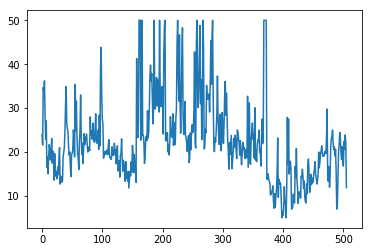

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(y)

In [34]:
pipe = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MaxAbsScaler()),
    ], include_bypass=True)), # this will produce one setting without scaler
    ('regressor', PipelineHelper([
        ('rf', RandomForestRegressor()),
        ('ada', AdaBoostRegressor()),
        ('gb', GradientBoostingRegressor()),
    ])),
])

params = {
    'scaler__selected_model': pipe.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
        # no params for 'max' leads to using standard params
    }),
    'regressor__selected_model': pipe.named_steps['regressor'].generate({

        'rf__n_estimators': [10, 20],

        'ada__n_estimators': [10, 20],
        
        'gb__n_estimators': [10, 20],
        #'gb__criterion': ['friedman_mse', 'mse', 'mae'],
        #'gb__max_features': ['auto', 'sqrt', None],

    })
}
grid = GridSearchCV(pipe, params, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, return_train_score=True)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_.decision_function(X))

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s


{'regressor__selected_model': ('rf', {'n_estimators': 10}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': False})}
-27.41712608695652
None


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.8s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [35]:
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regressor__selected_model,param_scaler__selected_model,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.026035,0.000000,-27.417126,-2.121529,"(rf, {'n_estimators': 10})","(std, {'with_mean': True, 'with_std': False})","{'regressor__selected_model': ('rf', {'n_estim...",1,-10.189778,-2.794439,-27.574961,-2.174025,-44.588243,-1.396122,7.366596e-03,0.000000,14.036558,0.572066
5,0.026035,0.000000,-28.873305,-1.781403,"(rf, {'n_estimators': 10})","(None, {}, True)","{'regressor__selected_model': ('rf', {'n_estim...",2,-8.302500,-2.424125,-30.776126,-1.572546,-47.652407,-1.347537,7.363785e-03,0.000000,16.112965,0.463664
11,0.046865,0.000000,-28.903251,-1.469765,"(rf, {'n_estimators': 20})","(None, {}, True)","{'regressor__selected_model': ('rf', {'n_estim...",3,-9.290991,-1.707056,-32.118273,-1.590325,-45.398091,-1.111915,0.000000e+00,0.000000,14.908186,0.257487
6,0.057278,0.000000,-29.773320,-1.574397,"(rf, {'n_estimators': 20})","(std, {'with_mean': True, 'with_std': True})","{'regressor__selected_model': ('rf', {'n_estim...",4,-12.202377,-2.009331,-30.714959,-1.480838,-46.501607,-1.233023,1.472813e-02,0.000000,14.011497,0.323757
9,0.046864,0.005207,-29.839364,-1.538114,"(rf, {'n_estimators': 20})","(std, {'with_mean': False, 'with_std': False})","{'regressor__selected_model': ('rf', {'n_estim...",5,-10.834350,-1.927962,-30.986804,-1.502737,-47.803233,-1.183645,0.000000e+00,0.007364,15.106827,0.304894
10,0.052072,0.005207,-29.944476,-1.497373,"(rf, {'n_estimators': 20})","(max, {})","{'regressor__selected_model': ('rf', {'n_estim...",6,-9.507586,-2.117622,-33.048459,-1.202714,-47.380555,-1.171783,1.948457e-02,0.007363,15.609408,0.438764
8,0.052071,0.000000,-30.388750,-1.449941,"(rf, {'n_estimators': 20})","(std, {'with_mean': False, 'with_std': True})","{'regressor__selected_model': ('rf', {'n_estim...",7,-10.373598,-1.712748,-31.715595,-1.479207,-49.188299,-1.157867,7.363785e-03,0.000000,15.865982,0.227473
7,0.046864,0.000000,-30.547899,-1.427307,"(rf, {'n_estimators': 20})","(std, {'with_mean': True, 'with_std': False})","{'regressor__selected_model': ('rf', {'n_estim...",8,-12.159487,-1.952922,-30.787968,-1.294526,-48.804268,-1.034474,0.000000e+00,0.000000,14.953677,0.386531
4,0.031238,0.000000,-31.095703,-1.871603,"(rf, {'n_estimators': 10})","(max, {})","{'regressor__selected_model': ('rf', {'n_estim...",9,-8.723346,-2.015631,-37.736112,-2.042304,-46.921293,-1.556874,0.000000e+00,0.000000,16.280388,0.222813
2,0.015622,0.000000,-31.473498,-1.765727,"(rf, {'n_estimators': 10})","(std, {'with_mean': False, 'with_std': True})","{'regressor__selected_model': ('rf', {'n_estim...",10,-11.423721,-2.706131,-35.263171,-1.281989,-47.830387,-1.309062,3.781439e-06,0.000000,15.096008,0.665058


##  Iris (classification)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from pipelinehelper import PipelineHelper

X, y = datasets.load_iris(True)

pipe = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MaxAbsScaler()),
    ], include_bypass=True)), # this will produce one setting without scaler
    ('classifier', PipelineHelper([
        ('svm', SVC()),
        ('rf', RandomForestClassifier()),
        ('ada', AdaBoostClassifier()),
        ('gb', GradientBoostingClassifier()),
        ('knn', KNeighborsClassifier()),
        
        ('nb_pipe', Pipeline([
            # Naivie Bayes needs positive numbers
            ('scaler', MinMaxScaler()),
            ('nb', MultinomialNB())
        ])),
    ])),
])

params = {
    'scaler__selected_model': pipe.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
        # no params for 'max' leads to using standard params
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({

        'svm__C': [0.1, 1.0],
        'svm__kernel': ['linear', 'rbf'],

        'rf__n_estimators': [10, 20, 50, 100, 150],
        'rf__max_features': ['auto', 'sqrt', 'log2'],
        'rf__min_samples_split' : [2, 5, 10],
        'rf__min_samples_leaf' : [1, 2, 4],
        'rf__bootstrap': [True, False],

        'ada__n_estimators': [10, 20, 40, 100],
        'ada__algorithm': ['SAMME', 'SAMME.R'],
        
        'gb__n_estimators': [10, 20, 50, 100],
        'gb__criterion': ['friedman_mse', 'mse', 'mae'],
        'gb__max_features': ['auto', 'sqrt', None],

        'knn__n_neighbors': [2, 3, 5, 7, 10],
        'knn__leaf_size':[1,2,3,5],
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['auto', 'ball_tree','kd_tree','brute'],

        'nb_pipe__nb__fit_prior': [True, False],
        'nb_pipe__nb__alpha': [0.1, 0.2],
    })
}
grid = GridSearchCV(pipe, params, scoring='accuracy', verbose=2, n_jobs=-1, return_train_score=True)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_.decision_function(X))

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 2892 candidates, totalling 8676 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1482 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 3694 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 4826 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 7220 tasks      | elapsed:   53.1s


{'classifier__selected_model': ('knn', {'n_neighbors': 5, 'leaf_size': 1, 'weights': 'uniform', 'algorithm': 'auto'}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': False})}
0.9866666666666667
None


[Parallel(n_jobs=-1)]: Done 8676 out of 8676 | elapsed:   57.2s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classifier__selected_model,param_scaler__selected_model,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2305,0.000000,0.000000,0.986667,0.966726,"(knn, {'n_neighbors': 5, 'leaf_size': 1, 'weig...","(std, {'with_mean': True, 'with_std': False})","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,0.959596,0.980392,0.979798,1.000000,0.960784,0.000000e+00,0.000000e+00,0.009147,0.009256
2713,0.000000,0.000000,0.986667,1.000000,"(knn, {'n_neighbors': 10, 'leaf_size': 1, 'wei...","(std, {'with_mean': True, 'with_std': False})","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,1.000000,0.980392,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.009147,0.000000
2709,0.000000,0.000000,0.986667,1.000000,"(knn, {'n_neighbors': 10, 'leaf_size': 1, 'wei...","(std, {'with_mean': False, 'with_std': False})","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,1.000000,0.980392,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.009147,0.000000
2707,0.000000,0.000000,0.986667,1.000000,"(knn, {'n_neighbors': 10, 'leaf_size': 1, 'wei...","(std, {'with_mean': True, 'with_std': False})","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,1.000000,0.980392,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.009147,0.000000
2705,0.000000,0.005207,0.986667,1.000000,"(knn, {'n_neighbors': 10, 'leaf_size': 1, 'wei...","(None, {}, True)","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,1.000000,0.980392,1.000000,1.000000,1.000000,0.000000e+00,7.364122e-03,0.009147,0.000000
2341,0.000000,0.005207,0.986667,0.966726,"(knn, {'n_neighbors': 5, 'leaf_size': 2, 'weig...","(std, {'with_mean': True, 'with_std': False})","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,0.959596,0.980392,0.979798,1.000000,0.960784,0.000000e+00,7.363897e-03,0.009147,0.009256
2343,0.000000,0.005207,0.986667,0.966726,"(knn, {'n_neighbors': 5, 'leaf_size': 2, 'weig...","(std, {'with_mean': False, 'with_std': False})","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,0.959596,0.980392,0.979798,1.000000,0.960784,0.000000e+00,7.363897e-03,0.009147,0.009256
2345,0.000000,0.000000,0.986667,0.966726,"(knn, {'n_neighbors': 5, 'leaf_size': 2, 'weig...","(None, {}, True)","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,0.959596,0.980392,0.979798,1.000000,0.960784,0.000000e+00,0.000000e+00,0.009147,0.009256
2797,0.000000,0.000000,0.986667,1.000000,"(knn, {'n_neighbors': 10, 'leaf_size': 3, 'wei...","(std, {'with_mean': True, 'with_std': False})","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,1.000000,0.980392,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.009147,0.000000
2347,0.000000,0.000000,0.986667,0.966726,"(knn, {'n_neighbors': 5, 'leaf_size': 2, 'weig...","(std, {'with_mean': True, 'with_std': False})","{'classifier__selected_model': ('knn', {'n_nei...",1,0.980392,0.959596,0.980392,0.979798,1.000000,0.960784,0.000000e+00,0.000000e+00,0.009147,0.009256


# Custom GridSearchCV

In [86]:
from abc import ABCMeta, abstractmethod
from collections import Mapping, namedtuple, defaultdict, Sequence, Iterable
from functools import partial, reduce
from itertools import product
import operator
import time
import warnings

import numpy as np
from scipy.stats import rankdata

from sklearn.base import BaseEstimator, is_classifier, clone
from sklearn.base import MetaEstimatorMixin

from sklearn.model_selection import GridSearchCV, ParameterGrid, ParameterSampler
from sklearn.model_selection._split import check_cv
from sklearn.model_selection._validation import _fit_and_score, _aggregate_score_dicts, _score
from sklearn.exceptions import NotFittedError
from sklearn.externals.joblib import Parallel, delayed, logger
from sklearn.externals import six
from sklearn.utils import check_random_state
from sklearn.utils.fixes import sp_version
from sklearn.utils.fixes import MaskedArray
from sklearn.utils.random import sample_without_replacement
from sklearn.utils.validation import indexable, check_is_fitted, _is_arraylike, _num_samples
from sklearn.utils.metaestimators import if_delegate_has_method, _safe_split
from sklearn.utils.deprecation import DeprecationDict
from sklearn.metrics.scorer import _check_multimetric_scoring
from sklearn.metrics.scorer import check_scoring

In [87]:
def my_fit_and_score(estimator, X, y, scorer, train, test, verbose,
                   parameters, fit_params, return_train_score=False,
                   return_parameters=False, return_n_test_samples=False,
                   return_times=False, return_estimator=False,
                   error_score='raise-deprecating'):
    """Fit estimator and compute scores for a given dataset split.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    scorer : A single callable or dict mapping scorer name to the callable
        If it is a single callable, the return value for ``train_scores`` and
        ``test_scores`` is a single float.
        For a dict, it should be one mapping the scorer name to the scorer
        callable object / function.
        The callable object / fn should have signature
        ``scorer(estimator, X, y)``.
    train : array-like, shape (n_train_samples,)
        Indices of training samples.
    test : array-like, shape (n_test_samples,)
        Indices of test samples.
    verbose : integer
        The verbosity level.
    error_score : 'raise' | 'raise-deprecating' or numeric
        Value to assign to the score if an error occurs in estimator fitting.
        If set to 'raise', the error is raised.
        If set to 'raise-deprecating', a FutureWarning is printed before the
        error is raised.
        If a numeric value is given, FitFailedWarning is raised. This parameter
        does not affect the refit step, which will always raise the error.
        Default is 'raise-deprecating' but from version 0.22 it will change
        to np.nan.
    parameters : dict or None
        Parameters to be set on the estimator.
    fit_params : dict or None
        Parameters that will be passed to ``estimator.fit``.
    return_train_score : boolean, optional, default: False
        Compute and return score on training set.
    return_parameters : boolean, optional, default: False
        Return parameters that has been used for the estimator.
    return_n_test_samples : boolean, optional, default: False
        Whether to return the ``n_test_samples``
    return_times : boolean, optional, default: False
        Whether to return the fit/score times.
    return_estimator : boolean, optional, default: False
        Whether to return the fitted estimator.
    Returns
    -------
    train_scores : dict of scorer name -> float, optional
        Score on training set (for all the scorers),
        returned only if `return_train_score` is `True`.
    test_scores : dict of scorer name -> float, optional
        Score on testing set (for all the scorers).
    n_test_samples : int
        Number of test samples.
    fit_time : float
        Time spent for fitting in seconds.
    score_time : float
        Time spent for scoring in seconds.
    parameters : dict or None, optional
        The parameters that have been evaluated.
    estimator : estimator object
        The fitted estimator
    """
    if verbose > 1:
        if parameters is None:
            msg = ''
        else:
            msg = '%s' % (', '.join('%s=%s' % (k, v)
                          for k, v in parameters.items()))
        print("[CV] %s %s" % (msg, (64 - len(msg)) * '.'))

    # Adjust length of sample weights
    fit_params = fit_params if fit_params is not None else {}
    fit_params = dict([(k, _index_param_value(X, v, train))
                      for k, v in fit_params.items()])

    train_scores = {}
    if parameters is not None:
        estimator.set_params(**parameters)

    start_time = time.time()

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, y_test = _safe_split(estimator, X, y, test, train)

    is_multimetric = not callable(scorer)
    n_scorers = len(scorer.keys()) if is_multimetric else 1

    try:
        if y_train is None:
            estimator.fit(X_train, **fit_params)
        else:
            estimator.fit(X_train, y_train, **fit_params)

    except Exception as e:
        # Note fit time as time until error
        fit_time = time.time() - start_time
        score_time = 0.0
        if error_score == 'raise':
            raise
        elif error_score == 'raise-deprecating':
            warnings.warn("From version 0.22, errors during fit will result "
                          "in a cross validation score of NaN by default. Use "
                          "error_score='raise' if you want an exception "
                          "raised or error_score=np.nan to adopt the "
                          "behavior from version 0.22.",
                          FutureWarning)
            raise
        elif isinstance(error_score, numbers.Number):
            if is_multimetric:
                test_scores = dict(zip(scorer.keys(),
                                   [error_score, ] * n_scorers))
                if return_train_score:
                    train_scores = dict(zip(scorer.keys(),
                                        [error_score, ] * n_scorers))
            else:
                test_scores = error_score
                if return_train_score:
                    train_scores = error_score
            warnings.warn("Estimator fit failed. The score on this train-test"
                          " partition for these parameters will be set to %f. "
                          "Details: \n%s" %
                          (error_score, format_exception_only(type(e), e)[0]),
                          FitFailedWarning)
        else:
            raise ValueError("error_score must be the string 'raise' or a"
                             " numeric value. (Hint: if using 'raise', please"
                             " make sure that it has been spelled correctly.)")

    else:
        fit_time = time.time() - start_time
        # _score will return dict if is_multimetric is True
        test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        score_time = time.time() - start_time - fit_time
        if return_train_score:
            train_scores = _score(estimator, X_train, y_train, scorer,
                                  is_multimetric)

    if verbose > 2:
        if is_multimetric:
            for scorer_name, score in test_scores.items():
                msg += ", %s=%s" % (scorer_name, score)
        else:
            msg += ", score=%s" % test_scores
    if verbose > 1:
        total_time = score_time + fit_time
        end_msg = "%s, total=%s" % (msg, logger.short_format_time(total_time))
        print("[CV] %s %s" % ((64 - len(end_msg)) * '.', end_msg))

    ret = [train_scores, test_scores] if return_train_score else [test_scores]

    if return_n_test_samples:
        ret.append(_num_samples(X_test))
    if return_times:
        ret.extend([fit_time, score_time])
    if return_parameters:
        ret.append(parameters)
    if return_estimator:
        ret.append(estimator)
    return ret

In [88]:
class MyGridSearchCV(GridSearchCV):

    def __init__(self, estimator, param_grid, scoring=None, fit_params=None,
                 n_jobs=1, iid='warn', refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', error_score='raise-deprecating',
                 return_train_score="warn"):
        super(MyGridSearchCV, self).__init__(
            estimator=estimator, param_grid = param_grid, scoring=scoring, fit_params=fit_params,
            n_jobs=n_jobs, iid=iid, refit=refit, cv=cv, verbose=verbose,
            pre_dispatch=pre_dispatch, error_score=error_score,
            return_train_score=return_train_score)

    def _get_param_iterator(self):
        """Return ParameterGrid instance for the given param_grid"""
        return ParameterGrid(self.param_grid)
    
    def fit(self, X, y=None, groups=None, **fit_params):
        """Run fit with all sets of parameters.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] or [n_samples, n_output], optional
            Target relative to X for classification or regression;
            None for unsupervised learning.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        **fit_params : dict of string -> object
            Parameters passed to the ``fit`` method of the estimator
        """

        if self.fit_params is not None:
            warnings.warn('"fit_params" as a constructor argument was '
                          'deprecated in version 0.19 and will be removed '
                          'in version 0.21. Pass fit parameters to the '
                          '"fit" method instead.', DeprecationWarning)
            if fit_params:
                warnings.warn('Ignoring fit_params passed as a constructor '
                              'argument in favor of keyword arguments to '
                              'the "fit" method.', RuntimeWarning)
            else:
                fit_params = self.fit_params
        estimator = self.estimator
        cv = check_cv(self.cv, y, classifier=is_classifier(estimator))

        scorers, self.multimetric_ = _check_multimetric_scoring(
            self.estimator, scoring=self.scoring)

        if self.multimetric_:
            if self.refit is not False and (
                    not isinstance(self.refit, six.string_types) or
                    # This will work for both dict / list (tuple)
                    self.refit not in scorers):
                raise ValueError("For multi-metric scoring, the parameter "
                                 "refit must be set to a scorer key "
                                 "to refit an estimator with the best "
                                 "parameter setting on the whole data and "
                                 "make the best_* attributes "
                                 "available for that metric. If this is not "
                                 "needed, refit should be set to False "
                                 "explicitly. %r was passed." % self.refit)
            else:
                refit_metric = self.refit
        else:
            refit_metric = 'score'

        X, y, groups = indexable(X, y, groups)
        n_splits = cv.get_n_splits(X, y, groups)

        base_estimator = clone(self.estimator)

        parallel = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
                            pre_dispatch=self.pre_dispatch)

        fit_and_score_kwargs = dict(scorer=scorers,
                                    fit_params=fit_params,
                                    return_train_score=self.return_train_score,
                                    return_n_test_samples=True,
                                    return_times=True,
                                    return_parameters=False,
                                    error_score=self.error_score,
                                    verbose=self.verbose)
        results_container = [{}]
        with parallel:
            all_candidate_params = []
            all_out = []

            def evaluate_candidates(candidate_params):
                candidate_params = list(candidate_params)
                n_candidates = len(candidate_params)

                if self.verbose > 0:
                    print("Fitting {0} folds for each of {1} candidates,"
                          " totalling {2} fits".format(
                              n_splits, n_candidates, n_candidates * n_splits))

                out = parallel(delayed(my_fit_and_score)(clone(base_estimator),
                                                       X, y,
                                                       train=train, test=test,
                                                       parameters=parameters,
                                                       **fit_and_score_kwargs)
                               for parameters, (train, test) in product(candidate_params, cv.split(X, y, groups)))
                
                print('-------------')
                print(out)
                print('-------------')
                
                all_candidate_params.extend(candidate_params)
                all_out.extend(out)

                # XXX: When we drop Python 2 support, we can use nonlocal
                # instead of results_container
                results_container[0] = self._format_results(
                    all_candidate_params, scorers, n_splits, all_out)
                return results_container[0]

            self._run_search(evaluate_candidates)

        results = results_container[0]

        # For multi-metric evaluation, store the best_index_, best_params_ and
        # best_score_ iff refit is one of the scorer names
        # In single metric evaluation, refit_metric is "score"
        if self.refit or not self.multimetric_:
            self.best_index_ = results["rank_test_%s" % refit_metric].argmin()
            self.best_params_ = results["params"][self.best_index_]
            self.best_score_ = results["mean_test_%s" % refit_metric][
                self.best_index_]

        if self.refit:
            self.best_estimator_ = clone(base_estimator).set_params(
                **self.best_params_)
            refit_start_time = time.time()
            if y is not None:
                self.best_estimator_.fit(X, y, **fit_params)
            else:
                self.best_estimator_.fit(X, **fit_params)
            refit_end_time = time.time()
            self.refit_time_ = refit_end_time - refit_start_time

        # Store the only scorer not as a dict for single metric evaluation
        self.scorer_ = scorers if self.multimetric_ else scorers['score']

        self.cv_results_ = results
        self.n_splits_ = n_splits

        return self
    
    def _format_results(self, candidate_params, scorers, n_splits, out):
        n_candidates = len(candidate_params)

        # if one choose to see train score, "out" will contain train score info
        if self.return_train_score:
            (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,
             score_time) = zip(*out)
        else:
            (test_score_dicts, test_sample_counts, fit_time,
             score_time) = zip(*out)

        # test_score_dicts and train_score dicts are lists of dictionaries and
        # we make them into dict of lists
        test_scores = _aggregate_score_dicts(test_score_dicts)
        if self.return_train_score:
            train_scores = _aggregate_score_dicts(train_score_dicts)

        # TODO: replace by a dict in 0.21
        results = (DeprecationDict() if self.return_train_score == 'warn'
                   else {})

        def _store(key_name, array, weights=None, splits=False, rank=False):
            """A small helper to store the scores/times to the cv_results_"""
            # When iterated first by splits, then by parameters
            # We want `array` to have `n_candidates` rows and `n_splits` cols.
            array = np.array(array, dtype=np.float64).reshape(n_candidates,
                                                              n_splits)
            if splits:
                for split_i in range(n_splits):
                    # Uses closure to alter the results
                    results["split%d_%s"
                            % (split_i, key_name)] = array[:, split_i]

            array_means = np.average(array, axis=1, weights=weights)
            results['mean_%s' % key_name] = array_means
            # Weighted std is not directly available in numpy
            array_stds = np.sqrt(np.average((array -
                                             array_means[:, np.newaxis]) ** 2,
                                            axis=1, weights=weights))
            results['std_%s' % key_name] = array_stds

            if rank:
                results["rank_%s" % key_name] = np.asarray(
                    rankdata(-array_means, method='min'), dtype=np.int32)

        _store('fit_time', fit_time)
        _store('score_time', score_time)
        # Use one MaskedArray and mask all the places where the param is not
        # applicable for that candidate. Use defaultdict as each candidate may
        # not contain all the params
        param_results = defaultdict(partial(MaskedArray,
                                            np.empty(n_candidates,),
                                            mask=True,
                                            dtype=object))
        for cand_i, params in enumerate(candidate_params):
            for name, value in params.items():
                # An all masked empty array gets created for the key
                # `"param_%s" % name` at the first occurrence of `name`.
                # Setting the value at an index also unmasks that index
                param_results["param_%s" % name][cand_i] = value

        results.update(param_results)
        # Store a list of param dicts at the key 'params'
        results['params'] = candidate_params

        # NOTE test_sample counts (weights) remain the same for all candidates
        test_sample_counts = np.array(test_sample_counts[:n_splits],
                                      dtype=np.int)
        iid = self.iid
        if self.iid == 'warn':
            warn = False
            for scorer_name in scorers.keys():
                scores = test_scores[scorer_name].reshape(n_candidates,
                                                          n_splits)
                means_weighted = np.average(scores, axis=1,
                                            weights=test_sample_counts)
                means_unweighted = np.average(scores, axis=1)
                if not np.allclose(means_weighted, means_unweighted,
                                   rtol=1e-4, atol=1e-4):
                    warn = True
                    break

            if warn:
                warnings.warn("The default of the `iid` parameter will change "
                              "from True to False in version 0.22 and will be"
                              " removed in 0.24. This will change numeric"
                              " results when test-set sizes are unequal.",
                              DeprecationWarning)
            iid = True

        for scorer_name in scorers.keys():
            # Computed the (weighted) mean and std for test scores alone
            _store('test_%s' % scorer_name, test_scores[scorer_name],
                   splits=True, rank=True,
                   weights=test_sample_counts if iid else None)
            if self.return_train_score:
                prev_keys = set(results.keys())
                _store('train_%s' % scorer_name, train_scores[scorer_name],
                       splits=True)
                if self.return_train_score == 'warn':
                    for key in set(results.keys()) - prev_keys:
                        message = (
                            'You are accessing a training score ({!r}), '
                            'which will not be available by default '
                            'any more in 0.21. If you need training scores, '
                            'please set return_train_score=True').format(key)
                        # warn on key access
                        results.add_warning(key, message, FutureWarning)

        return results

In [89]:
grid = MyGridSearchCV(pipe, params, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, return_train_score=True)
grid.fit(X, y)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s


-------------
[[{'score': -2.6507928783382795}, {'score': -9.531124852071002}, 169, 0.031244754791259766, 0.0], [{'score': -2.0629370919881307}, {'score': -32.61000118343197}, 169, 0.031241893768310547, 0.0], [{'score': -1.2371855029585797}, {'score': -48.93207797619047}, 168, 0.031244754791259766, 0.0], [{'score': -2.1451264094955493}, {'score': -10.620964497041422}, 169, 0.031241893768310547, 0.0], [{'score': -1.8595611275964392}, {'score': -35.42857337278106}, 169, 0.031241893768310547, 0.0], [{'score': -1.3862576923076917}, {'score': -48.08989285714285}, 168, 0.031241893768310547, 0.0], [{'score': -1.9374744807121669}, {'score': -11.596113609467455}, 169, 0.031241893768310547, 0.0], [{'score': -1.3542824925816022}, {'score': -34.711149704142024}, 169, 0.015620231628417969, 0.0], [{'score': -1.2533618343195267}, {'score': -47.28721726190476}, 168, 0.034368276596069336, 0.0], [{'score': -2.7131370919881306}, {'score': -11.821550887573965}, 169, 0.01874232292175293, 0.0], [{'score': -

[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.8s finished
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:238: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


MyGridSearchCV(cv=None, error_score='raise-deprecating',
        estimator=Pipeline(memory=None,
     steps=[('scaler', PipelineHelper(available_models={'std': StandardScaler(copy=True, with_mean=True, with_std=True), 'max': MaxAbsScaler(copy=True)},
        include_bypass=True, selected_model=None)), ('regressor', PipelineHelper(available_models={'rf': RandomForestRegressor(bootstrap=True, criterio...on_fraction=0.1, verbose=0, warm_start=False)},
        include_bypass=False, selected_model=None))]),
        fit_params=None, iid='warn', n_jobs=-1,
        param_grid={'scaler__selected_model': [('std', {'with_mean': True, 'with_std': True}), ('std', {'with_mean': True, 'with_std': False}), ('std', {'with_mean': False, 'with_std': True}), ('std', {'with_mean': False, 'with_std': False}), ('max', {}), (None, {}, True)], 'regressor__selected_model': [('rf', {'n_estimators': 10}), ('rf', {'n_estimators': 20}), ('ada', {'n_estimators': 10}), ('ada', {'n_estimators': 20}), ('gb', {'n_estima